In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import geopandas as gpd


In [100]:
grid = 10
grid_size = (grid, grid)
sub_grid_size = grid//2
nodes = grid * grid

In [101]:
def plot(weights, iteration):
    # Creating grid of 10 x 10 color patches
    fig, ax = plt.subplots()
    for i in range(10):
        for j in range(10):
            ax.add_patch(plt.Rectangle((i, j), 1, 1, color=weights[i*10+j]))

    plt.axis('scaled')
    plt.title(f'SOM - Iteration: {iteration}')
    plt.show()

In [102]:
# Reading data from csv
data = pd.read_csv('Q1_countrydata.csv')

data = data.drop(['Province_State'], axis=1)
# data = data.drop(['Country_Region'], axis=1)
data = data.drop(['Last_Update'], axis=1)
data = data.drop(['Lat'], axis=1)
data = data.drop(['Long_'], axis=1)

# sum of confirmed, deaths and recovered for each Country_Region
data = data.groupby('Country_Region').sum().reset_index()

# log 
data['Confirmed'] = np.log1p(data['Confirmed'])
data['Deaths'] = np.log1p(data['Deaths'])
data['Recovered'] = np.log1p(data['Recovered'])

# # Normalize Confirmed, Deaths and Recovered columns with max
data['Confirmed'] = data['Confirmed'] / data['Confirmed'].max()
data['Deaths'] = data['Deaths'] / data['Deaths'].max()
data['Recovered'] = data['Recovered'] / data['Recovered'].max()

data
# data.describe()


,Country_Region,Confirmed,Deaths,Recovered
0,Afghanistan,0.644347,0.601697,0.660360
1,Albania,0.652382,0.553982,0.648290
2,Algeria,0.683820,0.620003,0.690316
3,Andorra,0.534955,0.347495,0.553532
4,Angola,0.580583,0.470189,0.578666
...,...,...,...,...
186,Vietnam,0.433638,0.280295,0.446839
187,West Bank and Gaza,0.703829,0.569211,0.726135
188,Yemen,0.454353,0.501776,0.449517
189,Zambia,0.591692,0.467259,0.611341


In [103]:
# get random values for the weights of the nodes nodes x 3 (RGB) - range: 0.1 to 1
weights = np.random.rand(nodes, 3) * 0.9 + 0.1

SOM Training Started
Iteration:  0


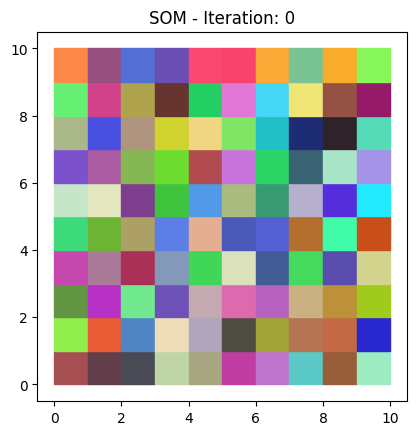

Iteration:  1000


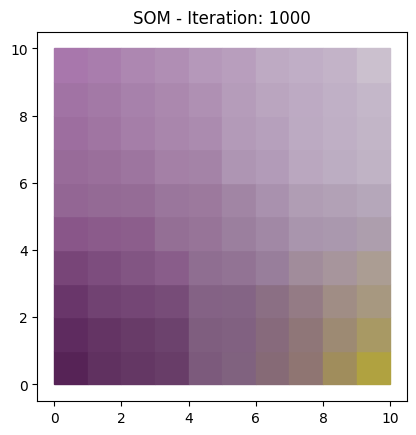

Iteration:  2000


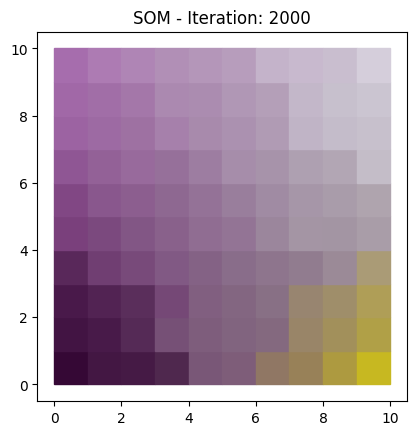

Iteration:  3000


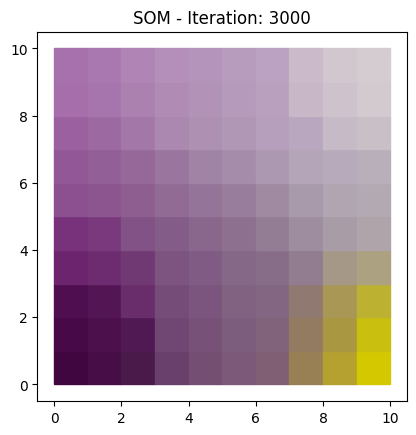

SOM Training Completed


In [104]:
# Training SOM

iterations = 4000
learning_decay_rate = 0.2
radius_decay_rate = 5
learning_decay = learning_decay_rate
radius_decay = radius_decay_rate

print("SOM Training Started")
for i in range(iterations):
    random_row = data.sample()

    index = random_row.index.values[0]
    random_row = random_row.to_numpy()
    country, confirmed, deaths, recovered = random_row[0].tolist()

    diff_array = [pow((weight[0] - confirmed)**2 + (weight[1] - deaths)**2 + (weight[2] - recovered)**2, 1/2) for weight in weights]
    bmu = min(diff_array)
    index_bmu = np.unravel_index(diff_array.index(bmu), (grid, grid))

    for index in range(nodes):
        twod_index = np.unravel_index(index, (grid, grid))
        distance_to_bmu = pow((twod_index[0] - index_bmu[0])**2 + (twod_index[1] - index_bmu[1])**2, 1/2)
        if distance_to_bmu < radius_decay:
            theta = math.exp(-((distance_to_bmu**2)/(2*(radius_decay**2))))
            weights[index] = weights[index] + learning_decay * theta * ([confirmed, deaths, recovered] - weights[index])

    learning_decay = learning_decay_rate * math.exp((-i/iterations))
    radius_decay = radius_decay_rate * math.exp((-i/iterations))

    if i % 1000 == 0:
        print("Iteration: ", i)
        plot(weights, i)


print("SOM Training Completed")

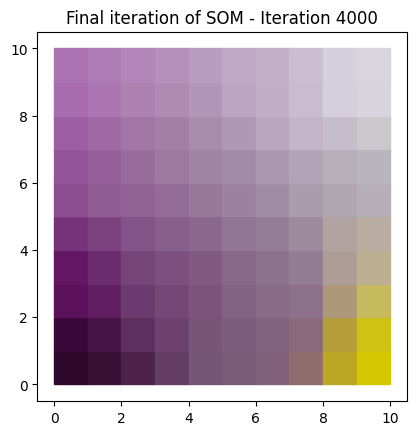

In [105]:
# Creating grid of 10 x 10 color patches
fig, ax = plt.subplots()
for i in range(10):
    for j in range(10):
        ax.add_patch(plt.Rectangle((i, j), 1, 1, color=weights[i*10+j]))

plt.axis('scaled')
plt.title(f'Final iteration of SOM - Iteration {iterations}')
plt.show()

C:\Users\Jezzel\AppData\Local\Temp\ipykernel_14656\249868361.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


TypeError: unhashable type: 'list'

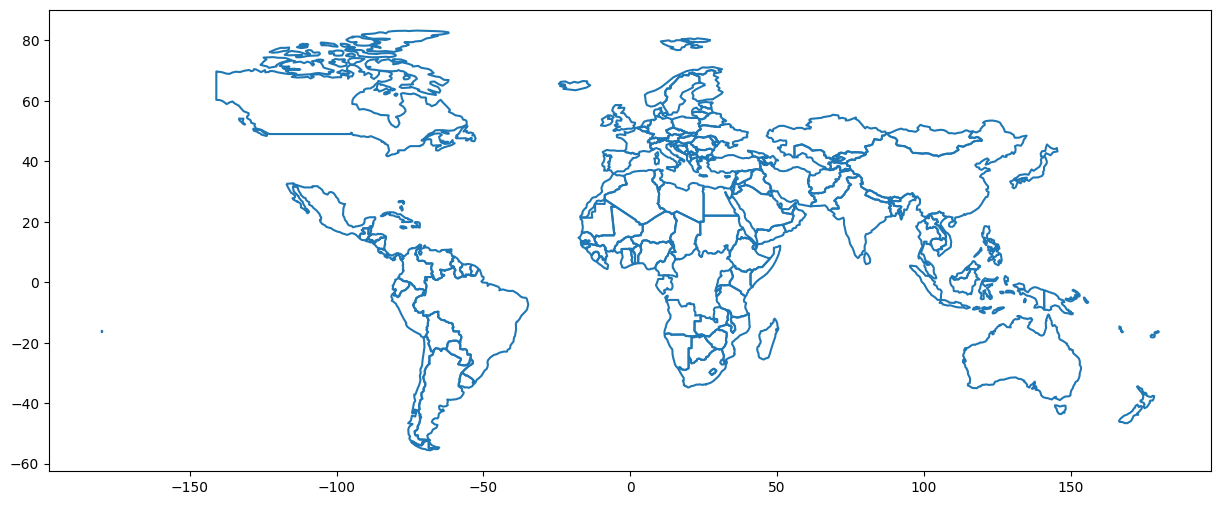

In [132]:
data.head()

data['Color'] = None

for index, row in data.iterrows():
    country, confirmed, deaths, recovered, color = row
    diff_array = [pow((weight[0] - confirmed)**2 + (weight[1] - deaths)**2 + (weight[2] - recovered)**2, 1/2) for weight in weights]
    bmu = min(diff_array)
    index_bmu = np.unravel_index(diff_array.index(bmu), (grid, grid))
    color = weights[index_bmu[0]*10 + index_bmu[1]]
    # print(f'{country} - BMU: {index_bmu} - Color: {color}')
    data.at[index, 'Color'] = list(color) + [1]

data.to_csv('Q1_countrydata_som.csv', index=False)


data.head()

C:\Users\Jezzel\AppData\Local\Temp\ipykernel_14656\4042804586.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


ValueError: Invalid RGBA argument: nan

<Figure size 640x480 with 0 Axes>

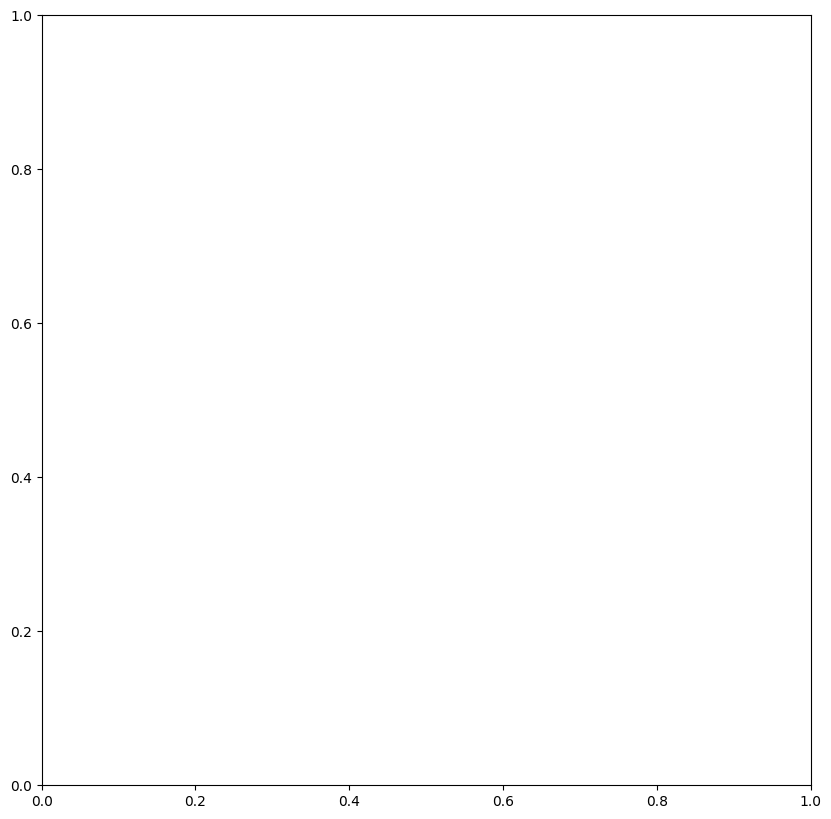

In [131]:
from ast import literal_eval

# Creating World Map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, facecolor='lightgray', edgecolor='black')

merged_data = world.merge(data, how='left', left_on='name', right_on='Country_Region')

fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(ax=ax, color=merged_data['Color'], legend=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Self Organizing Map Visualization with Countries')
plt.show()
